<a href="https://colab.research.google.com/github/annien094/PINNs-tutorial-MICCAI-2024/blob/main/PINNs_AP2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome to the second part of the PINNs tutorial!**

In this notebook, we will set up a PINN to solve the Aliev-Panfilov model that describes the electrical potential propagation in the heart.

We will be using a data file **APdata.mat**. Make sure you have the data file in your Drive where you save this notebook so the data can be loaded.

## Set up: install and import required packages

Note: it will be useful to connect to a GPU for this tutorial. Select **Runtime** -> **Change runtime type** -> select the GPU available eg. T4 GPU, before running the cell below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/MyDrive/
## change to wherever you have the data file stored

# Setup
!pip install --upgrade tensorflow==2.17
!pip install --upgrade tensorflow-probability==0.24
!pip install --upgrade tf-keras==2.17
!pip install --upgrade deepxde==1.12.1
#!pip install --upgrade numpy
!pip install --upgrade matplotlib

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import argparse
import scipy.io
import numpy as np
import deepxde as dde #1.12.0
from deepxde.backend import tensorflow
# import warnings
# warnings.filterwarnings("ignore")
# module load cuda if needed

## PINNs setup

First, let's set up the hyperparameters of the network.

In [2]:
# Training Parameters
num_domain = 20000 # number of training points within the domain
num_boundary = 1000 # number of training boundary condition points on the geometry boundary
num_test = 1000 # number of testing points within the domain
MAX_MODEL_INIT = 5 # maximum number of times allowed to initialize the model
MAX_LOSS = 0.1 # upper limit to the initialized loss
epochs_init = 15000 # number of epochs for training initial phase
epochs_main = 400000 # number of epochs for main training phase
lr = 0.0005 # learning rate
test_size = 0.6 # split, fraction saved for test
input = 3
num_hidden_layers = 3
hidden_layer_size = 30
output = 2
out_path = 'AP1/'

Let's also set the parameters for the Aliev Panfilov model.

In [3]:
# Aliev Panfilov model parameters
a = 0.01
b = 0.15
D = 0.1
k = 8.0
mu_1 = 0.2
mu_2 = 0.3
epsilon = 0.002

Now, we load the training data, which was generated using a finite differences solver in Matlab.

In [4]:
# GT data loading
file_name = "APdata.mat"
!pwd
data = scipy.io.loadmat(file_name,squeeze_me=True)

tlin, xlin, ylin, vlin, Vsav, o_in, v_in, wlin = data["tlin"], data["xlin"], data["ylin"], data["vlin"], data["Vsav"], data["observe_in"], data["v_in"], data["wlin"]

max_t = np.max(tlin)
max_x = np.max(xlin)
max_y = np.max(ylin)
min_t = np.min(tlin)
min_x = np.min(xlin)
min_y = np.min(ylin)
X = xlin.reshape(-1, 1)
Y = ylin.reshape(-1, 1)
T = tlin.reshape(-1, 1)
V = vlin.reshape(-1, 1)
W = wlin.reshape(-1, 1)
spacing = xlin[1]-xlin[0]

observe_x = np.hstack((X, Y, T))

/content/drive/MyDrive


**Exercise**: define a function called pde that takes the network's input x and output y input, and return the residual between the network's predictions and the equations.

The Aliev-Panfilov equations are as follows:

$$
\frac{\partial V}{\partial t} = \nabla \cdot (D \nabla V) - kV (V - a) (V - 1) - VW
$$

$$
\frac{dW}{dt} = \left( \epsilon + \frac{\mu_1 W}{V + \mu_2} \right) \left( -W - kV (V - b - 1) \right).
$$

V(x, y, t) is the transmembrane potential, for which we have some experimental data. W(x, y, t) is a latent variable that is not measurable. We will solve the coupled systems for both variables in this exercise.

In [ ]:
# Complete the unfinished code
def pde(x, y):

    V, W = y[:, 0:1], y[:, 1:2]

    dv_dt = #...
    dv_dxx = #...
    dv_dyy = #...
    dw_dt = #...

    eq_a = #...
    eq_b = #...
    return [eq_a, eq_b]

In [5]:
# @title Solution
def pde(x, y):

    V, W = y[:, 0:1], y[:, 1:2]
#
    dv_dt = dde.grad.jacobian(y, x, i=0, j=2)
    dv_dxx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    dv_dyy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dw_dt = dde.grad.jacobian(y, x, i=1, j=2)

    eq_a = dv_dt -  D*(dv_dxx + dv_dyy) + k*V*(V-a)*(V-1) +W*V
    eq_b = dw_dt -  (epsilon + (mu_1*W)/(mu_2+V))*(-W -k*V*(V-b-1))
    return [eq_a, eq_b]

We define:


*   IC_func, taking the training data points near time zero as the initial conditions.
*   BC_func, to employ the no-flux Neumann boundary condition. This is to prevent a leakage of V (potential) to regions outside the heart domain.

We then split the loaded data randomly into a train and a test set using `train_test_split()`.



In [6]:
# Initial and boundary conditions
def IC_func(observe_train, v_train):

    T_ic = observe_train[:,-1].reshape(-1,1)
    idx_init = np.where(np.isclose(T_ic,0))[0]
    v_init = v_train[idx_init]
    observe_init = observe_train[idx_init]
    print(np.shape(v_init))
    print(np.shape(observe_init))
    return dde.PointSetBC(observe_init,v_init,component=0)

def boundary_func_2d(x, on_boundary):
    return on_boundary and ~(x[0:2]==[min_x,min_y]).all() and  ~(x[0:2]==[min_x,max_y]).all() and ~(x[0:2]==[max_x,min_y]).all()  and  ~(x[0:2]==[max_x,max_y]).all()

def BC_func(geomtime):
    bc = dde.NeumannBC(geomtime, lambda x:  np.zeros((len(x), 1)), boundary_func_2d, component=0)
    return bc


observe_train, observe_test, v_train, v_test = train_test_split(observe_x,V,test_size=test_size)

**Exercise**: define the geometry of the problem as before. Note that we have a 2D spatial geometry and a temporal interval in this problem.
We also need to define the initial conditions for both equations and set up the experimental data for V.

In [ ]:
# Complete the unfinished code
geom = dde.geometry.Rectangle(...)
timedomain = dde.geometry.TimeDomain(...)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Define Boundary Conditions
bc = BC_func(geomtime)

## Define Initial Conditions
# Use the simulated data and the functions above
ic1 = IC_func() # this is the initial condition for V
ic2 = IC_func() # this is the initial condition for W,
# which should be 0 everywhere

## Include observed data as inputs to the network
# We only have observed data for V
observe_v = dde.PointSetBC(observe_train, v_train, component=0)
input_data = [bc, ic1, ic2, observe_v]

In [7]:
# @title Solution
geom = dde.geometry.Rectangle([min_x,min_y], [max_x,max_y])
timedomain = dde.geometry.TimeDomain(min_t, max_t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Define Boundary Conditions
bc = BC_func(geomtime)

## Define Initial Conditions
ic1 = IC_func(observe_train, v_train)
ic2 = IC_func(observe_train, np.zeros_like(v_train))

## Include observed data as inputs to the network
observe_v = dde.PointSetBC(observe_train, v_train, component=0)
input_data = [bc, ic1, ic2, observe_v]

(3642, 1)
(3642, 3)
(3642, 1)
(3642, 3)


As before, we need to create

*   net
*   data

And then combine then into a Model.



In [8]:
net = dde.maps.FNN([input] + [hidden_layer_size] * num_hidden_layers + [output], "tanh", "Glorot uniform")
pde_data = dde.data.TimePDE(geomtime, pde, input_data,
                            num_domain = num_domain,
                            num_boundary=num_boundary,
                            anchors=observe_train,
                            num_test=num_test)
model = dde.Model(pde_data, net)
model.compile("adam", lr=lr)

Compiling model...
Building feed-forward neural network...
'build' took 0.247488 s

'compile' took 3.759797 s



Here, we define a scheme to cap the initial loss from the network. We only allow the network to continue training if the initial loss is lower than a threshold. Otherwise, we will re-initialise the network.

In [21]:
def stable_init(model):
    ## Stabilize initialization process by capping the losses
    losshistory, _ = model.train(epochs=1)
    initial_loss = max(losshistory.loss_train[0])
    num_init = 1
    while initial_loss>MAX_LOSS or np.isnan(initial_loss):
        num_init += 1
        model = dde.Model(pde_data, net)
        model.compile("adam", lr=lr)
        losshistory, _ = model.train(epochs=1)
        initial_loss = max(losshistory.loss_train[0])
        if num_init > MAX_MODEL_INIT:
            raise ValueError('Model initialization phase exceeded the allowed limit')
    return 0

Now, let's customise a model training funtion with 3 phases:


1.   train with data loss only, using Adam (Hint: use the `loss_weights` argument in `model.compile()` to set the other loss terms to zero.)
2.   train with all loss terms, using Adam
3.   train with all loss terms, using L-BFGS-B to help with convergence

We then train the model. Feel free to try both the 3-phase training and 1-phase training schemes. Do you observe any differences in the performance?


In [ ]:
def train_3_phase(out_path):
    init_weights = #...

    ## Initial phase with data term only
    model.compile("adam", lr=lr, loss_weights=init_weights)
    losshistory, train_state = model.train(iterations=epochs_init, model_save_path = out_path)

    ## Main phase with all terms


    ## Final phase with L-BFGS-B


    return losshistory, train_state

def train_1_phase(out_path):
    losshistory, train_state = model.train(iterations=10000, model_save_path = out_path)
    return losshistory, train_state

# stable_init(model)
# losshistory, train_state = train_3_phases(model, out_path)
losshistory, train_state = train_1_phase(out_path)

In [9]:
#@title Solution
def train_3_phase(out_path):
    init_weights = [0,0,0,0,1]

    ## Initial phase
    model.compile("adam", lr=lr, loss_weights=init_weights)
    losshistory, train_state = model.train(iterations=epochs_init, model_save_path = out_path)
    ## Main phase
    model.compile("adam", lr=lr)
    losshistory, train_state = model.train(iterations=epochs_main, model_save_path = out_path)
    ## Final phase
    model.compile("L-BFGS-B")
    losshistory, train_state = model.train(model_save_path = out_path)
    return losshistory, train_state

def train_1_phase(out_path):
    losshistory, train_state = model.train(iterations=10000, model_save_path = out_path)
    return losshistory, train_state

# stable_init(model)
# losshistory, train_state = train_3_phase(model, out_path)
losshistory, train_state = train_1_phase(out_path)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.97e+00, 1.12e+00, 9.02e-04, 4.47e-02, 4.28e-02, 2.64e-01]    [4.12e+00, 9.71e-01, 9.02e-04, 4.47e-02, 4.28e-02, 2.64e-01]    []  
1000      [1.83e-02, 2.73e-02, 2.93e-03, 1.93e-03, 5.91e-05, 5.93e-02]    [1.90e-02, 2.64e-02, 2.93e-03, 1.93e-03, 5.91e-05, 5.93e-02]    []  
2000      [9.50e-03, 1.56e-02, 5.11e-03, 1.59e-03, 1.50e-04, 4.14e-02]    [9.19e-03, 1.47e-02, 5.11e-03, 1.59e-03, 1.50e-04, 4.14e-02]    []  
3000      [5.48e-03, 1.00e-02, 6.15e-03, 1.43e-03, 1.95e-04, 2.67e-02]    [4.99e-03, 9.31e-03, 6.15e-03, 1.43e-03, 1.95e-04, 2.67e-02]    []  
4000      [3.45e-03, 6.54e-03, 5.78e-03, 1.40e-03, 2.11e-04, 1.12e-02]    [2.94e-03, 6.16e-03, 5.78e-03, 1.40e-03, 2.11e-04, 1.12e-02]    []  
5000      [2.09e-03, 3.44e-03, 5.81e-03, 1.36e-03, 2.14e-04, 4.06e-03]    [1.78e-03, 3.19e-03, 5.81e-03, 1.36e-03, 2

After training, we can make predictions and check the RMSE for test data.

In [10]:
pred = model.predict(observe_test)
v_pred = pred[:,0:1]
rmse_v = np.sqrt(np.square(v_pred - v_test).mean())
print("V RMSE for test data:", rmse_v)

pred_2 = model.predict(observe_x)
v_pred_model = pred_2[:,0:1]
np.savetxt("v_pred_model_spiral.txt",np.hstack((observe_x,v_pred_model)),header="observe_x, v_pred_model")

dicti = {'pred': pred,'observe_test': observe_test, 'observe_train': observe_train, 'pred_all': pred_2, 'observe_x': observe_x, 'rmse_v': rmse_v}
scipy.io.savemat('out_path' + 'results.mat',dicti)

V RMSE for test data: 0.034236732826085796


Visualing the results at a user-defined position.

8.8


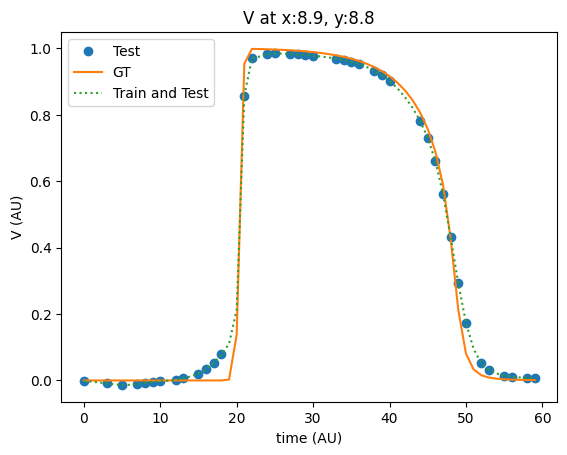

In [11]:
ind=observe_test[163965,0:2]
print(ind[1])
a=np.squeeze(np.isclose(observe_test[:,0:1],ind[0]))
b=np.squeeze(np.isclose(observe_test[:,1:2],ind[1]))
c=np.logical_and(a,b)
plt.plot(observe_test[c,2],pred[c,0:1],'o',label='Test')

a=np.squeeze(np.isclose(observe_x[:,0:1],ind[0]))
b=np.squeeze(np.isclose(observe_x[:,1:2],ind[1]))
c=np.logical_and(a,b)
plt.plot(observe_x[c,2],vlin[c],'-',label='GT')

plt.plot(observe_x[c,2],pred_2[c,0:1],':',label='Train and Test')

plt.legend()
plt.title('V at x:' + str(ind[0]) + ', y:' + str(ind[1]))
plt.ylabel('V (AU)')
plt.xlabel('time (AU)')
plt.show()